In [1]:
import random
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import WhitespaceTokenizer
from nltk import sent_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Length of text input - 250 words

EDA and preprocessing ||
removed contractions, stop words, certain punctuation, dropped rows w/ na values ||
dataset visualized and EDA carried out ||
data augmentation NOT applied ||

##DETAILS ABOUT MODEL:

layers - 
encoder -> LSTM1-> LSTM2 -> decoder 
decoder + LSTM2 -> attention
decoder + attention -> dense layer ||

hidden dim size - 70, embedding dim size - 30 ||

training parameters: batch size 128, epochs 200, early stopping after 20 epochs of no change

In [2]:
dataset = pd.read_csv('mtsamples.csv')
dataset.drop("Unnamed: 0", axis = 1, inplace=True)
dataset.drop("keywords", axis = 1, inplace=True)

In [3]:
dataset.drop_duplicates()

,description,medical_specialty,sample_name,transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...
...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e..."
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema..."
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen..."


In [4]:
dataset.shape

(4999, 4)

In [5]:
dataset.head()

,description,medical_specialty,sample_name,transcription
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...


In [6]:
#if package not found - run the next line of code
#nltk.download('stopwords')
#from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [7]:
dataset.dropna(axis = 0, inplace = True)

In [8]:
def remove_stopwords(text):
    if isinstance(text, str):
        new_text = []
        text = text.split()
        for word in text:
            if word not in stop_words:
                new_text.append(word)
        text = " ".join(new_text)
        return text

In [9]:
#from a kaggle notebook - will add reference 
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
def lowercase(object):
    if isinstance(object, str):
        object = str.lower(object)
    return object

def contractions(object):
    if isinstance(object, str):
        if object in contraction_mapping:
            temp_word = contraction_mapping[object]
            object = temp_word
    return object

def remove_punctuation(object):
    #leave ":" and "." - section and full stop, respectively. Info about sequences
    #remove "," ; "/" ; " "
    if isinstance(object, str): 
        expression = r"[!\#\$'\*\;%']"
        empty_str = ""
        result = re.sub(expression, empty_str, object, 0, re.MULTILINE)
        return result
    else:
        return object

"""def POS_tagger(object):
    if isinstance(object, str):
        #Map POS tag to first character lemmatize() accepts
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    else:
        return object"""
#flag 1,2,3 - 1 - lowercase, 2 - stopwords, 3 - contraction, 4 - punctuation,
#5 - lemmatizer
def apply_df(df, label, flag):
    if flag == 1:
        df.loc[:, label] = df[label].apply(lambda x : lowercase(x))
    elif flag == 2:
        df.loc[:, label] = df[label].apply(lambda x : remove_stopwords(x))
    elif flag == 3:
        df.loc[:, label] = df[label].apply(lambda x : contractions(x))
    elif flag == 4:
        df.loc[:, label] = df[label].apply(lambda x : remove_punctuation(x))
    return df
dataset = apply_df(dataset, 'transcription', 1)
dataset = apply_df(dataset, 'description', 1)
dataset.head()

,description,medical_specialty,sample_name,transcription
0,a 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"subjective:, this 23-year-old white female pr..."
1,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"past medical history:, he has difficulty climb..."
2,consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"history of present illness: , i have seen abc ..."
3,2-d m-mode. doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-d m-mode: , ,1. left atrial enlargement wit..."
4,2-d echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. the left ventricular cavity size and wall ...


In [11]:
dataset = apply_df(dataset, 'transcription', 2)
dataset = apply_df(dataset, 'description', 2)
dataset = apply_df(dataset, 'transcription', 3)
dataset = apply_df(dataset, 'description', 3)
dataset = apply_df(dataset, 'transcription', 4)
dataset = apply_df(dataset, 'description', 4)

Converted to lowercase, removed stop words, contractions and certain punctuations.

In [12]:
#refactor
medical_specialties_list = []
trans_word_count_list = []
summary_word_count_list = []
for word in dataset['medical_specialty'].unique():
    medical_specialties_list.append(word)
    dataset_filtered = dataset[(dataset['medical_specialty'] == word)]
    trans_word_count = dataset_filtered['transcription'].str.split().str.len().sum()
    summary_word_count = dataset_filtered['description'].str.split().str.len().sum()
    trans_word_count_list.append(trans_word_count)
    summary_word_count_list.append(summary_word_count)
    
words_df = pd.DataFrame({'specialty': medical_specialties_list, 'text_word_count': trans_word_count_list, 'summary_word_count': summary_word_count_list})
words_df['text_word_count'] = words_df['text_word_count'].astype('int')
words_df['summary_word_count'] = words_df['summary_word_count'].astype('int')
words_df = words_df.sort_values('text_word_count', ascending=False)
words_df = words_df.sort_values('summary_word_count', ascending=False)
words_df.reset_index(drop=True, inplace = True)

In [13]:
words_df.head()

,specialty,text_word_count,summary_word_count
0,Surgery,311281,15697
1,Consult - History and Phy.,174469,6381
2,Cardiovascular / Pulmonary,100753,5648
3,Orthopedic,118102,5559
4,General Medicine,74040,3091


In [14]:
#all the different medical_specialty values:
dataset['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

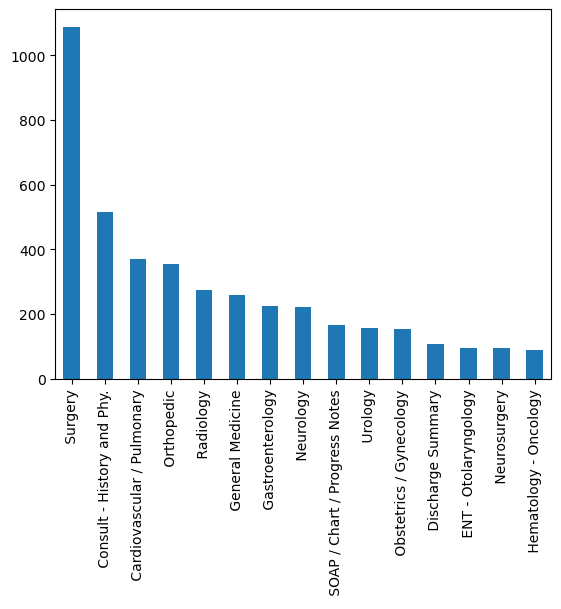

In [15]:
med_counts = dataset['medical_specialty'].value_counts()
ax = med_counts[:15].plot.bar(y = "Freq")
#frequency distribution of number of records - first 15

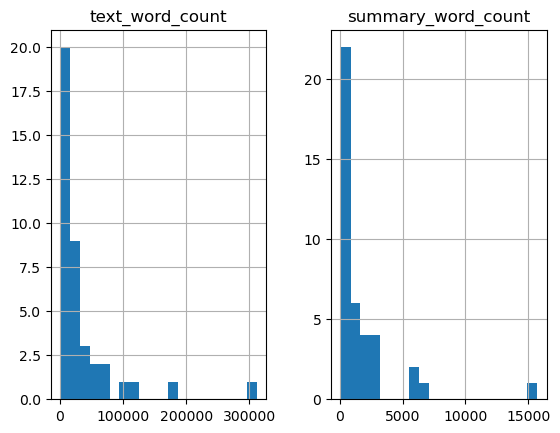

In [16]:
import matplotlib.pyplot as plt
words_df.hist(bins = 20)
plt.show()
#as expected, most text and summary counts are in the lowest 3 bins possible
#look at the difference in length between texts and summaries!

In [17]:
print(words_df['text_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))
print("\n")
print(words_df['summary_word_count'].describe(percentiles = [0.25, 0.5, 0.75, 0.90]))

count        40.000000
mean      34751.825000
std       57400.031418
min        1316.000000
25%        6276.500000
50%       15805.500000
75%       35214.000000
90%       76711.300000
max      311281.000000
Name: text_word_count, dtype: float64


count       40.000000
mean      1637.175000
std       2773.650634
min         66.000000
25%        190.750000
50%        669.000000
75%       1872.500000
90%       3337.800000
max      15697.000000
Name: summary_word_count, dtype: float64


In [18]:
train_dataset = dataset.drop('sample_name', axis = 1)
train_dataset = train_dataset.drop('medical_specialty', axis = 1)

In [19]:
train_dataset.head()

,description,transcription
0,23-year-old white female presents complaint al...,"subjective:, 23-year-old white female presents..."
1,consult laparoscopic gastric bypass.,"past medical history:, difficulty climbing sta..."
2,consult laparoscopic gastric bypass.,"history present illness: , seen abc today. ple..."
3,2-d m-mode. doppler.,"2-d m-mode: , ,1. left atrial enlargement left..."
4,2-d echocardiogram,1. left ventricular cavity size wall thickness...


In [20]:
print(train_dataset['description'].describe())
print("\n")
print(train_dataset['transcription'].describe())

count                                                  4966
unique                                                 2336
top       example/template routine normal male physical ...
freq                                                     12
Name: description, dtype: object


count                                                  4966
unique                                                 2357
top       preoperative diagnosis: , low back pain.,posto...
freq                                                      5
Name: transcription, dtype: object


### No data augmentation
#### Shuffle Sentence Transform affects the Sentence Centrality of the dataset, negatively affecting the model's ability to learn useful patterns pertaining to the medical transcriptions.
#### TODO - try other forms of data augmentation. (e.g. replace words with others that mean the same thing, paraphrase sentences while maintaing the location of the sentence, etc.)

In [48]:
dataset = train_dataset

In [49]:
dataset.tail()

,description,transcription
4994,patient severe sinusitis two three months ago ...,"history:, pleasure meeting evaluating patient ..."
4995,14-month-old baby boy caucasian came presumpti...,"admitting diagnosis: , kawasaki disease.,disch..."
4996,female complete physical follow asthma allergi...,"subjective: , 42-year-old white female comes t..."
4997,mother states wheezing coughing.,"chief complaint: , 5-year-old male presents ch..."
4998,"acute allergic reaction, etiology uncertain, h...","history: , 34-year-old male presents today sel..."


In [50]:
dataset.describe()

,description,transcription
count,4966,4966
unique,2336,2357
top,example/template routine normal male physical ...,"preoperative diagnosis: , low back pain.,posto..."
freq,12,5


## Splitting train and test set

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(dataset['transcription']), np.array(dataset['description']), test_size = 0.05, random_state = 0, shuffle = True)

In [52]:
print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("x_val shape : ", x_val.shape)
print("y_val shape : ", y_val.shape)

x_train shape :  (4717,)
y_train shape :  (4717,)
x_val shape :  (249,)
y_val shape :  (249,)


## NLP

In [53]:
#<BOS> - begin of sequence; <EOS> - end of sequence.
def sequence_tagger(input_sequence):
    bos = "<BOS> "
    eos = " <EOS>"
    tagged_sequence = []
    for text in input_sequence:
        if isinstance(text, str):
            tagged_sentence = bos + text + eos
            tagged_sequence.append(tagged_sentence)
    return tagged_sequence

tagged_seq_x_train = sequence_tagger(x_train)

In [54]:
print(len(tagged_seq_x_train))
print(tagged_seq_x_train[1])

4717
<BOS> pre postoperative diagnosis:, left cervical radiculopathy c5, c6,operation: , left c5-6 hemilaminotomy foraminotomy medial facetectomy microscopic decompression nerve root.,after informed consent obtained patient, taken or. general anesthesia induced, ted hose stockings pneumatic compression stockings placed patient foley catheter also inserted. point, patients placed three point fixation mayfield head holder patient placed operating table prone position. patients posterior cervical area prepped draped usual sterile fashion. time patients incision site infiltrated 1 percent lidocaine epinephrine. scalpel used make approximate 3 cm skin incision cephalad prominent c7 spinous processes, could palpated. dissection spinous process using bovie cautery, clamp placed spinous processes cross table lateral x-ray taken. showed spinous process c4 level. therefore, soft tissue dissection carried caudally level next spinous processes presumed c5 identified. muscle dissected lamina latera

In [55]:
tagged_seq_x_val = sequence_tagger(x_val)
tagged_seq_y_train = sequence_tagger(y_train)
tagged_seq_y_val = sequence_tagger(y_val)

## Preparing a tokenizer and calculating no. of rare / common words

In [56]:
temp_list = tagged_seq_x_train

In [58]:
from keras.preprocessing.text import Tokenizer

2023-01-13 10:00:52.461843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 10:00:53.072770: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-13 10:00:54.489899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rkv/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/rkv/miniconda3/envs/tf/lib/
2023-01-13 10:00:54.491555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [59]:
x_train_list = list(filter(None, temp_list))

In [61]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_train_list)

In [62]:
temp_list = list(tagged_seq_y_train)
#print(temp_list[1])
y_train_list = list(filter(None, temp_list))

In [63]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train_list) #this object's internal vocab - these words

In [64]:
#refactor later
threshold = 16

total_words_desc = 0
total_words_summ = 0 
total_freq_desc = 0
total_freq_summ = 0 
rare_word_desc_count = 0
rare_word_summ_count = 0
rare_word_desc_freq = 0 
rare_word_summ_freq = 0
#less than say, 4 in the original text - now dataset is 4x size, so 16
#from internal vocabulary
for key, value in x_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_desc = total_words_desc + 1
    total_freq_desc = total_freq_desc + value
    if value < threshold :
        rare_word_desc_count = rare_word_desc_count + 1
        rare_word_desc_freq = rare_word_desc_freq + value
print("Transcription : ")
print("Rare words consist of", (rare_word_desc_count / total_words_desc) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_desc_freq/total_freq_desc) * 100)

for key, value in y_tokenizer.word_counts.items():
    #returns a word and it's frequency
    total_words_summ = total_words_summ + 1
    total_freq_summ = total_freq_summ + value
    if value < threshold :
        rare_word_summ_count = rare_word_summ_count + 1
        rare_word_summ_freq = rare_word_summ_freq + value

print("\nSummary : ")
print("Rare words consist of", (rare_word_summ_count / total_words_summ) * 100, "% of the vocabulary")
#what does this following thing mean? :
print("Frequency of rare words relative to most frequent words(%):", (rare_word_summ_freq/total_freq_summ) * 100)



Transcription : 
Rare words consist of 67.33490043021244 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 5.045555658411106

Summary : 
Rare words consist of 84.48778709442216 % of the vocabulary
Frequency of rare words relative to most frequent words(%): 26.688128881046353


#### TO-DO : Try using the medical words embedding vector instead of building your own embedding

## Building the model

In [65]:
max_text_length = 250

In [66]:
#convert all the text sequences into tokenized sequences of integers
x_train_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_train)
x_val_seq = x_tokenizer.texts_to_sequences(tagged_seq_x_val)

y_train_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_train)
y_val_seq = y_tokenizer.texts_to_sequences(tagged_seq_y_val)

x_vocabulary = total_words_desc + 1
y_vocabulary = total_words_summ + 1

In [67]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [68]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [69]:
from keras import backend as K
K.clear_session()

#Building a seq2seq model
max_text_length = 250 
hidden_dim = 70
embedding_dim = 30

#Encoder
#Input data will be one-hot encoded and stored in encoder_inputs
encoder_inputs = Input(shape = (max_text_length, ))

#parameters - input_dim, output_dim, input_length
enc_emb = Embedding(x_vocabulary, embedding_dim, input_length = max_text_length, trainable = True)(encoder_inputs)

#encoded input to LSTM layer
encoder_LSTM = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
encoder_outputs_1, state_h1, state_c1 = encoder_LSTM(enc_emb)

#LSTM layer 1 to layer 2
LSTM_2 = LSTM(hidden_dim, return_sequences = True, return_state = True, dropout = 0.2)
encoder_outputs_2, state_h2, state_c2 = LSTM_2(encoder_outputs_1)

##Decoder - "encoder_states" is the initial state
decoder_inputs = Input(shape = (None,))

#Decoder embedding layer
dec_emb_layer = Embedding(y_vocabulary, embedding_dim, input_length = max_text_length, trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

#Decoder LSTM
decoder_LSTM = LSTM(hidden_dim, return_state = True, return_sequences = True, dropout = 0.2)
decoder_outputs, decoded_h, decoded_c = decoder_LSTM(dec_emb, initial_state = [state_h2, state_c2])

#Custom attention layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs_2, decoder_outputs])

#Concatenate attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = Dense(y_vocabulary, activation = 'softmax')
decoder_dense_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], attn_out)

2023-01-13 10:01:09.206531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 10:01:09.331797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 10:01:09.332448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-13 10:01:09.333456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 30)      676440      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 250, 70),    28280       ['embedding[0][0]']              
                                 (None, 70),                                                      
                                 (None, 70)]                                                      
                                                                                              

In [71]:
#current max_text_length = 250

from tensorflow.keras.preprocessing.sequence import pad_sequences

def padding(encoder_sequences, decoder_sequences, max_text_length):
  
    encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')
    decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_text_length, dtype='int32', padding='post', truncating='post')

    return encoder_input_data, decoder_input_data

In [72]:
print("Length of the first element of the input encoder sequence : ", len(x_train_seq[1]))
print("Length of the second element of the input encoder sequence : ", len(x_train_seq[2]))
print("Longest element in the input encoder seq. : ", len(max(x_train_seq, key = len)))
print("Longest element in the output decoder seq : ", len(max(y_train_seq, key = len)))

Length of the first element of the input encoder sequence :  308
Length of the second element of the input encoder sequence :  71
Longest element in the input encoder seq. :  1812
Longest element in the output decoder seq :  51


We can see they are all of very different lengths. To avoid this we pad all the texts to a fixed length, in this case 250.

In [73]:
#x_train_seq -> encoder sequence, BOS & EOS tagged
#y_train_seq -> decoder sequence, BOS & EOS tagged
x_train_final, y_train_final = padding(x_train_seq, y_train_seq, max_text_length)
x_val_final, y_val_final = padding(x_val_seq, y_val_seq, max_text_length)

In [74]:
print("Length of the first element of the input encoder sequence : ", len(x_train_final[1]))
print("Length of the first element of the output decoder sequence : ", len(y_train_final[1]))

Length of the first element of the input encoder sequence :  250
Length of the first element of the output decoder sequence :  250


In [75]:
print("Input encoder sequence size : ", len(x_train_final))
print("Output encoder sequence size : ", len(y_train_final))
print("Input validation sequence size : ", len(x_val_final))
print("Output validation sequence size : ", len(x_val_final))

Input encoder sequence size :  4717
Output encoder sequence size :  4717
Input validation sequence size :  249
Output validation sequence size :  249


In [76]:
from keras import optimizers

optimizer_obj = optimizers.RMSprop(learning_rate = 0.0005, clipvalue = 0.5)
model.compile(optimizer=optimizer_obj, loss='mean_squared_logarithmic_error')

Using early stopping to just get checkpoints, really.

In [77]:
es = [EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.00001, verbose=1,patience=20), ModelCheckpoint('./MyModel2_tf',monitor='val_loss', verbose=1)]

In [213]:
#loading weights after 1 checkpoint
#model.load_weights('./MyModel_tf')

In [78]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [79]:
history = model.fit([x_train_final,y_train_final[:, :-1]], y_train_final.reshape(y_train_final.shape[0],y_train_final.shape[1], 1)[:, 1:],epochs=200,callbacks=[es],batch_size=128, validation_data=([x_val_final,y_val_final[:, :-1]], y_val_final.reshape(y_val_final.shape[0],y_val_final.shape[1], 1)[:, 1:]))

Epoch 1/200


2023-01-13 10:02:01.308112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


37/37 [==============================] - ETA: 0s - loss: 1.8272
Epoch 1: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 156s 4s/step - loss: 1.8272 - val_loss: 1.7924
Epoch 2/200
37/37 [==============================] - ETA: 0s - loss: 1.6622
Epoch 2: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 136s 4s/step - loss: 1.6622 - val_loss: 1.5834
Epoch 3/200
37/37 [==============================] - ETA: 0s - loss: 1.5767
Epoch 3: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 133s 4s/step - loss: 1.5767 - val_loss: 1.5597
Epoch 4/200
37/37 [==============================] - ETA: 0s - loss: 1.5636
Epoch 4: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 150s 4s/step - loss: 1.5636 - val_loss: 1.5529
Epoch 5/200
37/37 [==============================] - ETA: 0s - loss: 1.5587
Epoch 5: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5587 - val_loss: 1.5504
Epoch 6/200
37/37 [==============================] - ETA: 0s - loss: 1.5564
Epoch 6: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5564 - val_loss: 1.5484
Epoch 7/200
37/37 [==============================] - ETA: 0s - loss: 1.5551
Epoch 7: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 149s 4s/step - loss: 1.5551 - val_loss: 1.5477
Epoch 8/200
37/37 [==============================] - ETA: 0s - loss: 1.5542
Epoch 8: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 140s 4s/step - loss: 1.5542 - val_loss: 1.5467
Epoch 9/200
37/37 [==============================] - ETA: 0s - loss: 1.5474
Epoch 9: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5474 - val_loss: 1.5243
Epoch 10/200
37/37 [==============================] - ETA: 0s - loss: 1.5308
Epoch 10: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 133s 4s/step - loss: 1.5308 - val_loss: 1.5241
Epoch 11/200
37/37 [==============================] - ETA: 0s - loss: 1.5307
Epoch 11: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 135s 4s/step - loss: 1.5307 - val_loss: 1.5240
Epoch 12/200
37/37 [==============================] - ETA: 0s - loss: 1.5306
Epoch 12: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 133s 4s/step - loss: 1.5306 - val_loss: 1.5240
Epoch 13/200
37/37 [==============================] - ETA: 0s - loss: 1.5306
Epoch 13: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5306 - val_loss: 1.5240
Epoch 14/200
37/37 [==============================] - ETA: 0s - loss: 1.5306
Epoch 14: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5306 - val_loss: 1.5240
Epoch 15/200
37/37 [==============================] - ETA: 0s - loss: 1.5306
Epoch 15: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 144s 4s/step - loss: 1.5306 - val_loss: 1.5240
Epoch 16/200
37/37 [==============================] - ETA: 0s - loss: 1.5215
Epoch 16: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5215 - val_loss: 1.5128
Epoch 17/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 17: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 146s 4s/step - loss: 1.5191 - val_loss: 1.5128
Epoch 18/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 18: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5191 - val_loss: 1.5128
Epoch 19/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 19: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 137s 4s/step - loss: 1.5191 - val_loss: 1.5128
Epoch 20/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 20: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 133s 4s/step - loss: 1.5191 - val_loss: 1.5128
Epoch 21/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 21: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 140s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 22/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 22: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 23/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 23: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 146s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 24/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 24: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 25/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 25: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 142s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 26/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 26: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 132s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 27/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 27: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 135s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 28/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 28: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 137s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 29/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 29: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 30/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 30: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 135s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 31/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 31: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 32/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 32: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 137s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 33/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 33: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 133s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 34/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 34: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 139s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 35/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 35: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 36/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 36: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 37/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 37: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 149s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 38/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 38: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 142s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 39/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 39: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 40/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 40: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 139s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 41/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 41: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 149s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 42/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 42: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 43/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 43: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 145s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 44/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 44: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 143s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 45/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 45: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 46/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 46: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 134s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 47/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 47: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 147s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 48/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 48: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 149s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 49/200
37/37 [==============================] - ETA: 0s - loss: 1.5191
Epoch 49: saving model to ./MyModel2_tf


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


INFO:tensorflow:Assets written to: ./MyModel2_tf/assets


37/37 [==============================] - 148s 4s/step - loss: 1.5191 - val_loss: 1.5127
Epoch 49: early stopping


In [253]:
#history.history

{'loss': [1.698223352432251,
  1.5697880983352661,
  1.5641767978668213,
  1.5620816946029663,
  1.5126267671585083,
  1.5125503540039062,
  1.5125476121902466],
 'val_loss': [1.5956496000289917,
  1.5820037126541138,
  1.5817384719848633,
  1.530390739440918,
  1.529829502105713,
  1.529823660850525,
  1.5298227071762085]}

In [80]:
#saving the entire model once training is completed.
model.save('saved_models/rkv_LSTM_model_200_epochs')

INFO:tensorflow:Assets written to: saved_models/rkv_LSTM_model_200_epochs/assets


INFO:tensorflow:Assets written to: saved_models/rkv_LSTM_model_200_epochs/assets


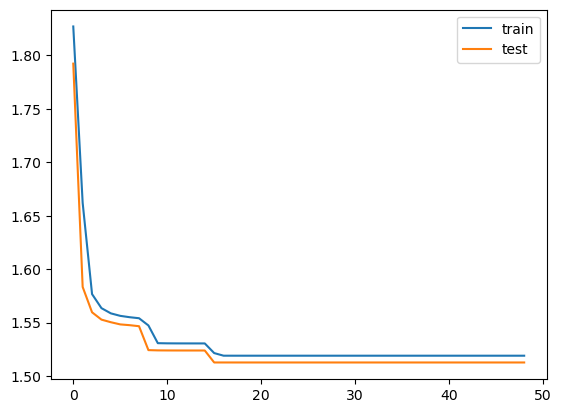

<Figure size 640x480 with 0 Axes>

In [81]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('rkv_LSTM_loss and val_loss.png')

In [ ]:
from tensorflow.keras.models import load_model

In [99]:
reloaded_model = load_model('saved_models/rkv_LSTM_model_att_augm')

In [82]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [83]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs_1, state_h1, state_c1])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_hidden_state_input = Input(shape=(max_text_length,hidden_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs3] + [state_h2, state_c2])

In [84]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['<BOS>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<EOS>'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == '<EOS>'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [85]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['bos']) and i!=target_word_index['eos']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2transcript(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [86]:
orig_dataset = pd.read_csv('mtsamples.csv')
orig_dataset.drop("Unnamed: 0", axis = 1, inplace=True)
orig_dataset.drop("keywords", axis = 1, inplace=True)
orig_dataset.drop_duplicates()
orig_dataset.dropna(axis = 0, inplace = True)

In [89]:
from datasets import load_metric
import csv

metric = load_metric("rouge")
data1 = pd.read_csv("mtsamples.csv") 

transcriptions = []
actual_summaries = []
predicted_summaries = []

transcriptions.append('transcription')
actual_summaries.append('actual_summaries')
predicted_summaries.append('predicted_summaries')

for i in range(len(y_train_final)):
    transcription_data = data1['transcription'][i]
    transcriptions.append(data1['transcription'][i])
    predicted_summaries.append(seq2summary(y_train_final[i]))
    
    actual_summaries.append(data1['description'][i])

rows = zip(transcriptions, actual_summaries, predicted_summaries)

with open('mtsamples_output.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

metric.compute(predictions=predicted_summaries, references=actual_summaries)

# for i in range(len(y_tr)):
#     print(seq2summary(y_tr[i]))

{'rouge1': AggregateScore(low=Score(precision=0.0186653790452829, recall=0.014767661845333168, fmeasure=0.014132335358691465), mid=Score(precision=0.02027889747730399, recall=0.016004910666841874, fmeasure=0.015231541170179053), high=Score(precision=0.021905847691840723, recall=0.017195152099272908, fmeasure=0.016359652404303145)),
 'rouge2': AggregateScore(low=Score(precision=0.001193935118379319, recall=0.0007830915415413423, fmeasure=0.0008570537857013891), mid=Score(precision=0.001643076967285829, recall=0.0011204289542379735, fmeasure=0.0011949642040776907), high=Score(precision=0.0021854180535483348, recall=0.0015185388070481005, fmeasure=0.001588781558792643)),
 'rougeL': AggregateScore(low=Score(precision=0.018141762053929804, recall=0.014193449463388451, fmeasure=0.013602756326093327), mid=Score(precision=0.019655978218299168, recall=0.015385931541428866, fmeasure=0.01467898444930019), high=Score(precision=0.021164787207098752, recall=0.016620346545119763, fmeasure=0.015809992

In [90]:
print("original : ", actual_summaries[3])
print("predicted : ", predicted_summaries[3])

original :   Consult for laparoscopic gastric bypass.
predicted :  patient reoccurring ingrown infected toenails 


In [91]:
print("original : ", actual_summaries[5])
print("predicted : ", predicted_summaries[5])

original :   2-D Echocardiogram
predicted :  patient referred hospitalized eventually diagnosed conversion disorder 


In [92]:
for i in range(25):
    print("original : ", actual_summaries[i])
    print("predicted : ", predicted_summaries[i])
    print("\n")

original :  actual_summaries
predicted :  predicted_summaries


original :   A 23-year-old white female presents with complaint of allergies.
predicted :  degenerative disk disease l4 l5 l5 s1 anterior exposure diskectomy fusion l4 l5 l5 s1 


original :   Consult for laparoscopic gastric bypass.
predicted :  left c5 6 hemilaminotomy foraminotomy medial facetectomy microscopic decompression nerve root 


original :   Consult for laparoscopic gastric bypass.
predicted :  patient reoccurring ingrown infected toenails 


original :   2-D M-Mode. Doppler.  
predicted :  common excretory urogram ivp template 


original :   2-D Echocardiogram
predicted :  patient referred hospitalized eventually diagnosed conversion disorder 


original :   Morbid obesity.  Laparoscopic antecolic antegastric Roux-en-Y gastric bypass with EEA anastomosis.  This is a 30-year-old female, who has been overweight for many years.  She has tried many different diets, but is unsuccessful. 
predicted :  patient mark

### Terrible results. While the model seems to generate sentences that are "grammatically" correct (e.g. a lady admitted with chest pain) appears to have chronic lung disease, reoccuring ingrown infected toenails, etc., they have almost no similarity to the original summary.

### Abstractive Text Summarization is not well-suited for practical applications on this dataset where the model shouldn't be a